In this example, we use CellCnn to analyze a mass cytometry dataset acquired to characterize human natural killer (NK) cell diversity and associate NK cell subsets with genetic and environmental factors, namely prior Cytomegalovirus (CMV) infection [1]. This dataset comprises mass cytometry measurements of 36 markers, including 28 NK cell receptors, for PBMC samples of 20 donors with varying serology for CMV. 

We will train CellCnn to identify CMV seropositivity-associated cell populations within the **manually gated NK cell compartment**. To run this example, please download the [NK cell dataset](http://www.imsb.ethz.ch/research/claassen/Software/cellcnn.html) and place the decompressed folder in the cellCnn/examples directory.

[1] Horowitz, A. et al. Genetic and environmental determinants of human NK cell diversity revealed by mass cytometry. Sci. Transl. Med. 5 (2013).


In [1]:
import os, sys, errno, glob
import numpy as np
import pandas as pd

import cellCnn
from cellCnn.utils import loadFCS, ftrans, mkdir_p, get_items
from cellCnn.model import CellCnn
from cellCnn.plotting import plot_results
from sklearn.metrics import roc_auc_score

%pylab inline


Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# define input and output directories
WDIR = os.path.join(cellCnn.__path__[0], 'examples')
FCS_DATA_PATH = os.path.join(WDIR, 'NK_cell_dataset', 'gated_NK')

# define output directory
OUTDIR = os.path.join(WDIR, 'output_NK')
mkdir_p(OUTDIR)

In [7]:
# look at the measured markers
data_fcs = loadFCS(glob.glob(FCS_DATA_PATH + '/*.fcs')[0], transform=None, auto_comp=False)
print(data_fcs.channels)

[u'Time', u'Cell_length', u'CD3', u'Dead', u'(La139)Dd', u'CD27', u'CD19', u'CD4', u'CD8', u'CD57', u'2DL1-S1', u'TRAIL', u'2DL2-L3-S2', u'CD16', u'CD10', u'3DL1-S1', u'CD117', u'2DS4', u'ILT2-CD85j', u'NKp46', u'NKG2D', u'NKG2C', u'2B4', u'CD33', u'CD11b', u'NKp30', u'CD122', u'3DL1', u'NKp44', u'CD127', u'2DL1', u'CD94', u'CD34', u'CCR7', u'2DL3', u'NKG2A', u'HLA-DR', u'2DL4', u'CD56', u'2DL5', u'CD25', u'DNA1', u'DNA2']


In [4]:
# select the relevant markers for further analysis
markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']
marker_idx = [data_fcs.channels.index(label) for label in markers]
nmark = len(markers)

In [5]:
# load the sample names and corresponding labels (0: CMV-, 1: CMV+), here from a CSV file
# prior CMV infection status is obtained from the original study (Horowitz et al. 2013)
csv_file = 'NK_fcs_samples_with_labels.csv'
fcs_info = np.array(pd.read_csv(csv_file, sep=','))
sample_ids = fcs_info[:, 0]
sample_labels = fcs_info[:, 1].astype(int)

In [6]:
# Here we randomly split the samples in training/validation/test sets.

# set random seed for reproducible results
np.random.seed(12345)

# cofactor for arcsinh transformation
cofactor = 5

# split the fcs files into training, validation and test set
group1 = np.where(sample_labels == 0)[0]
group2 = np.where(sample_labels == 1)[0]
l1, l2 = len(group1), len(group2)
ntrain_per_class = 7
ntest_group1 = l1 - ntrain_per_class
ntest_group2 = l2 - ntrain_per_class

# get the sample indices
train_idx1 = list(np.random.choice(group1, size=ntrain_per_class, replace=False))
test_idx1 = [i for i in group1 if i not in train_idx1]
train_idx2 = list(np.random.choice(group2, size=ntrain_per_class, replace=False))
test_idx2 = [i for i in group2 if i not in train_idx2]

# load the training samples
group1_list, group2_list = [], []
for idx in train_idx1:
    fname = os.path.join(FCS_DATA_PATH, sample_ids[idx])
    x_full = np.asarray(loadFCS(fname, transform=None, auto_comp=False))
    x = ftrans(x_full[:,marker_idx], cofactor)
    group1_list.append(x)

for idx in train_idx2:
    fname = os.path.join(FCS_DATA_PATH, sample_ids[idx])
    x_full = np.asarray(loadFCS(fname, transform=None, auto_comp=False))
    x = ftrans(x_full[:,marker_idx], cofactor)
    group2_list.append(x)

# load the test samples
t_group1_list, t_group2_list = [], []
test_phenotypes = []
for idx in test_idx1:
    fname = os.path.join(FCS_DATA_PATH, sample_ids[idx])
    x_full = np.asarray(loadFCS(fname, transform=None, auto_comp=False))
    x = ftrans(x_full[:,marker_idx], cofactor)
    t_group1_list.append(x)
    test_phenotypes.append(0)

for idx in test_idx2:
    fname = os.path.join(FCS_DATA_PATH, sample_ids[idx])
    x_full = np.asarray(loadFCS(fname, transform=None, auto_comp=False))
    x = ftrans(x_full[:,marker_idx], cofactor)
    t_group2_list.append(x)
    test_phenotypes.append(1)

# finally prepare training and vallidation data
cut = int(.8 * len(group1_list))
train_samples = group1_list[:cut] + group2_list[:cut]
train_phenotypes = [0] * len(group1_list[:cut]) + [1] * len(group2_list[:cut])
valid_samples = group1_list[cut:] + group2_list[cut:]
valid_phenotypes = [0] * len(group1_list[cut:]) + [1] * len(group2_list[cut:])
test_samples = t_group1_list + t_group2_list


In [7]:
# run a CellCnn analysis
model = CellCnn(ncell=200, nsubset=1000, verbose=0)

model.fit(train_samples=train_samples, train_phenotypes=train_phenotypes,
          valid_samples=valid_samples, valid_phenotypes=valid_phenotypes, outdir=OUTDIR)


Generating multi-cell inputs...
Done.
Number of filters: 7
Cells pooled: 1
1984/2000 [============================>.] - ETA: 0sBest validation accuracy: 0.92
Number of filters: 4
Cells pooled: 2
2000/2000 [==============================] - 0s     
Best validation accuracy: 0.88
Number of filters: 9
Cells pooled: 10
1984/2000 [============================>.] - ETA: 0sBest validation accuracy: 0.94
Number of filters: 4
Cells pooled: 40
2000/2000 [==============================] - 0s     
Best validation accuracy: 0.99
Number of filters: 9
Cells pooled: 200
2000/2000 [==============================] - 0s     
Best validation accuracy: 0.98
Number of filters: 9
Cells pooled: 1
2000/2000 [==============================] - 0s     
Best validation accuracy: 0.87
Number of filters: 9
Cells pooled: 2
2000/2000 [==============================] - 0s     
Best validation accuracy: 0.87
Number of filters: 9
Cells pooled: 10
1952/2000 [============================>.] - ETA: 0sBest validation accurac

In [16]:
# make predictions on the test cohort
test_pred = model.predict(test_samples)

# Each row in `test_pred` corresponds to a different sample
# and indicates the predicted class probabilities for that sample.
# Each row is a probability distribution and therefore always sums up to 1.
# Here we only have 2 classes: CMV- (1st column) and CMV+ (2nd column)

# look at the test set predictions
print '\nModel predictions:\n', test_pred

# and the true phenotypes of the test samples
print '\nTrue phenotypes:\n', test_phenotypes

Predictions based on multi-cell inputs containing 5652 cells.

Model predictions:
[[ 0.8936555   0.1063445 ]
 [ 0.91889727  0.08110273]
 [ 0.37275124  0.62724878]
 [ 0.21408841  0.7859116 ]
 [ 0.00700845  0.99299157]
 [ 0.16797403  0.83202595]]

True phenotypes:
[0, 0, 0, 0, 1, 1]


In [18]:
# calculate area under the ROC curve for the test set
test_auc = roc_auc_score(test_phenotypes, test_pred[:,1])
print test_auc

1.0


In [20]:
# plot the results of the CellCnn analysis for the test samples in the output directory
_ = plot_results(model.results, test_samples, test_phenotypes,
                 markers, OUTDIR, filter_response_thres=0,
                 filter_diff_thres=0.2, group_a='CMV-', group_b='CMV+')

Loading the weights of consensus filters.
Computing t-SNE projection...
Done.



Below we describe the plots generated in the output directory. Most of the actual files are in pdf format, but here, for illustration purposes, are displayed in png.

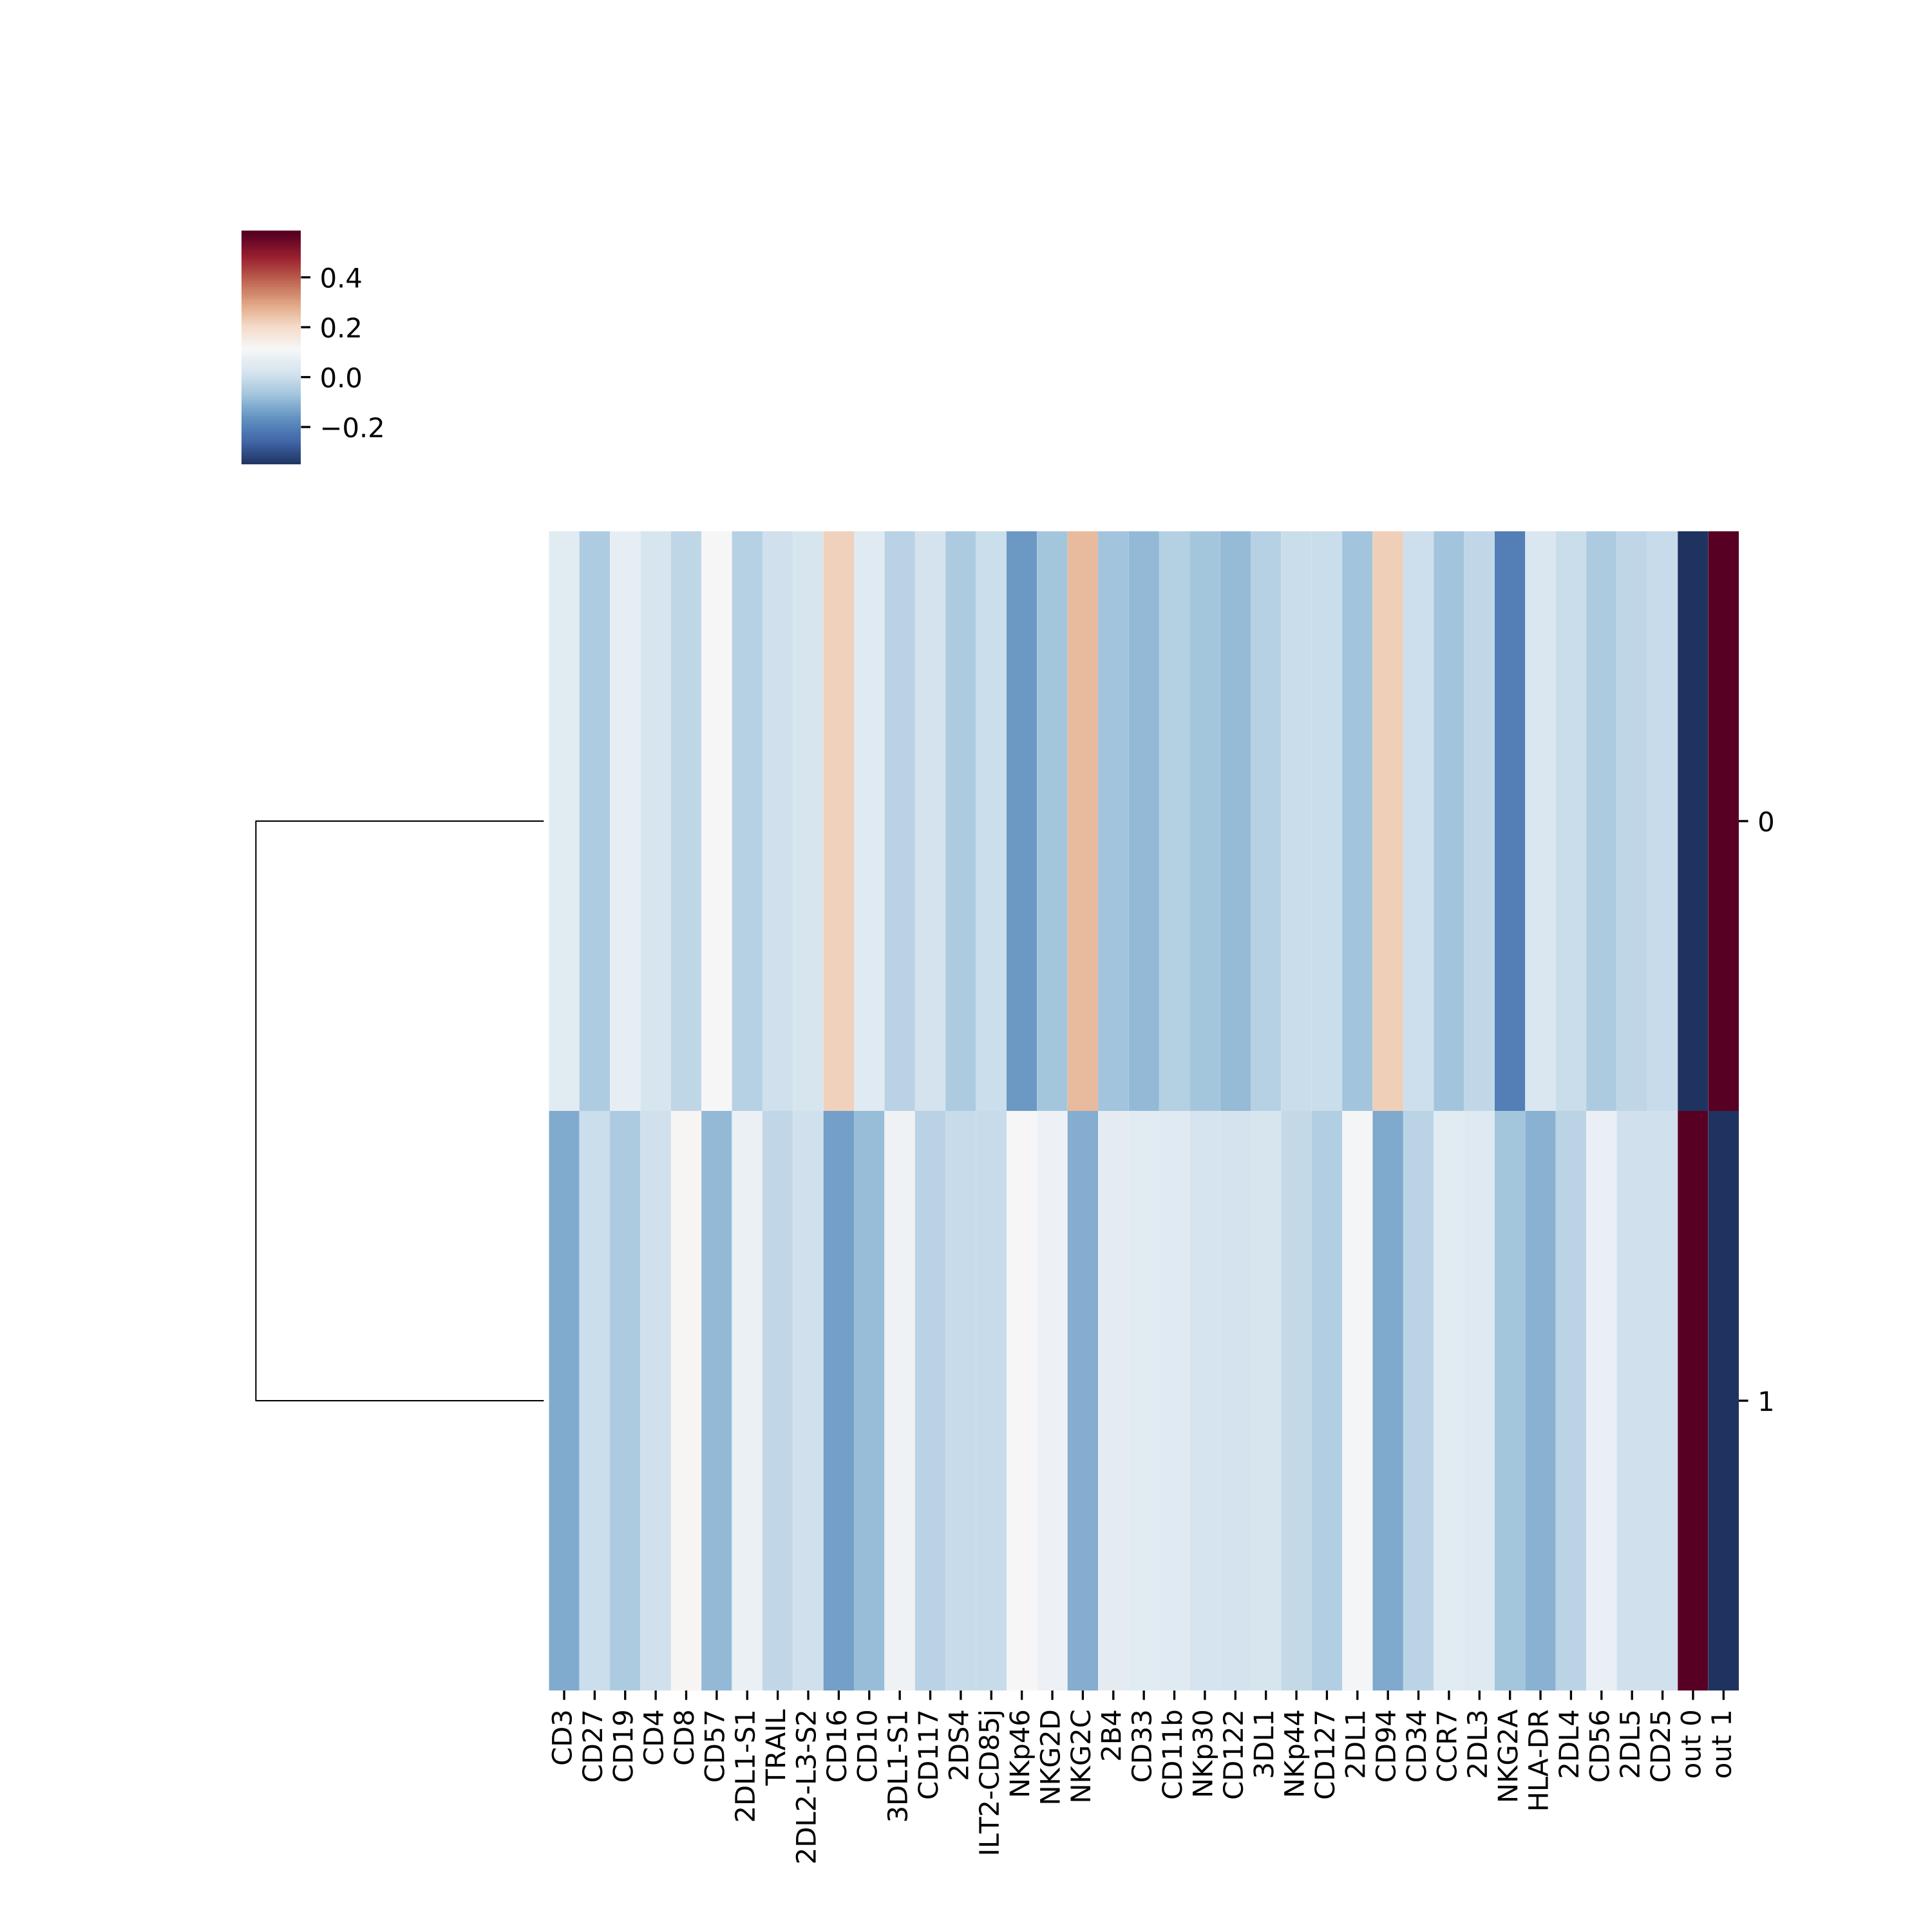

In [22]:
# In this example, we have two selected filters: filter 0 (first row) and filter 1 (second row).
# Filter 0 has high weights for the markers CD16, NKG2C and CD94
# and it is positively associated with class 1, that is CMV+ samples.

from IPython.display import Image
Image("./output_NK/consensus_filter_weights.png", width=600, height=350)

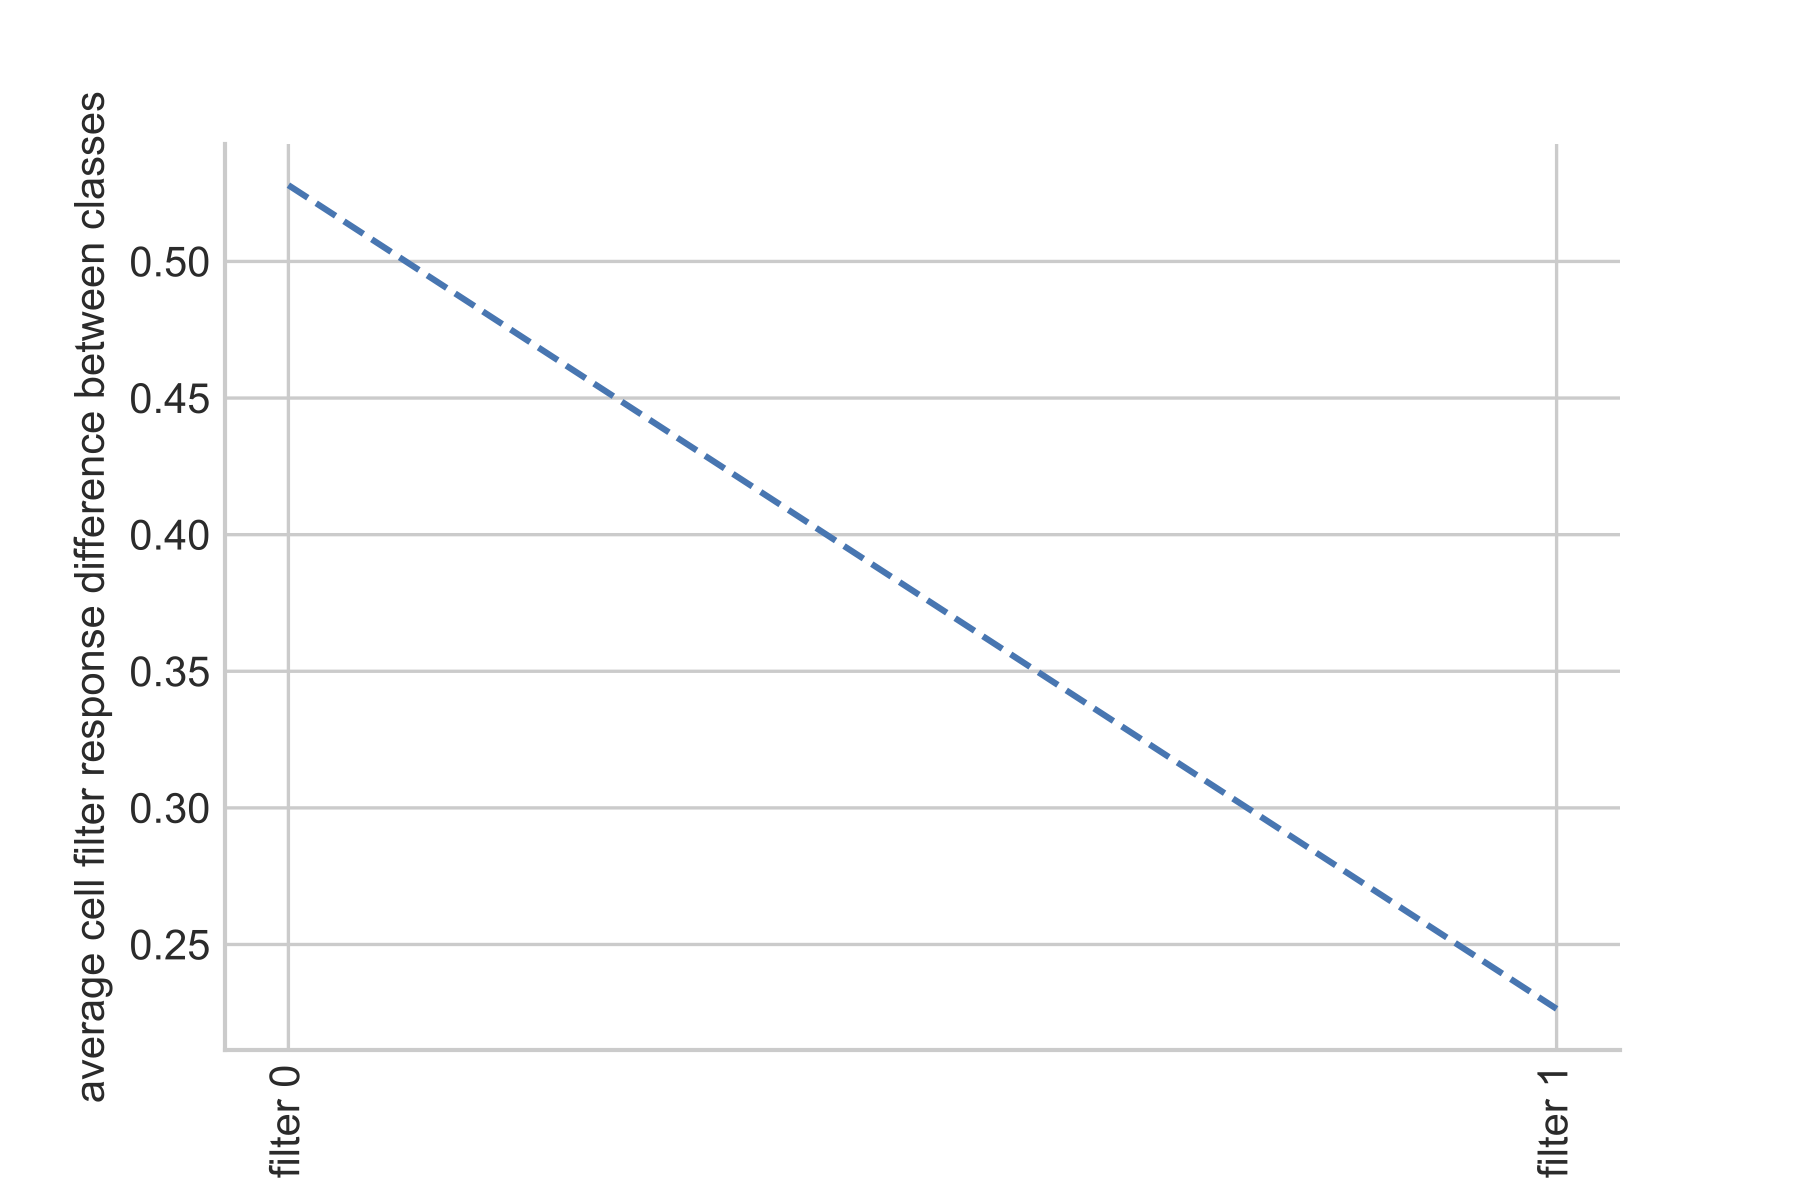

In [24]:
# We also see that filter 0 is more discriminative than filter 1,
# because the average cell filter response difference between CMV+
# and CMV- validation samples is higher for filter 0.

# The `filter_diff_thres` parameter (that is given as input to the `plot_results` function)
# is a threshold that defines which filters should be kept for further analysis.
# Given an array `filter_diff` of average cell filter response
# differences between classes (y-axis on the plot), sorted in decreasing order,
# we keep a filter `i, i > 0` if it holds that
# `filter_diff[i-1] - filter_diff[i] < filter_diff_thres * filter_diff[i-1]`.
# The default value is `filter_diff_thres`=0.2

Image("./output_NK/filter_response_differences.png", width=600, height=350)

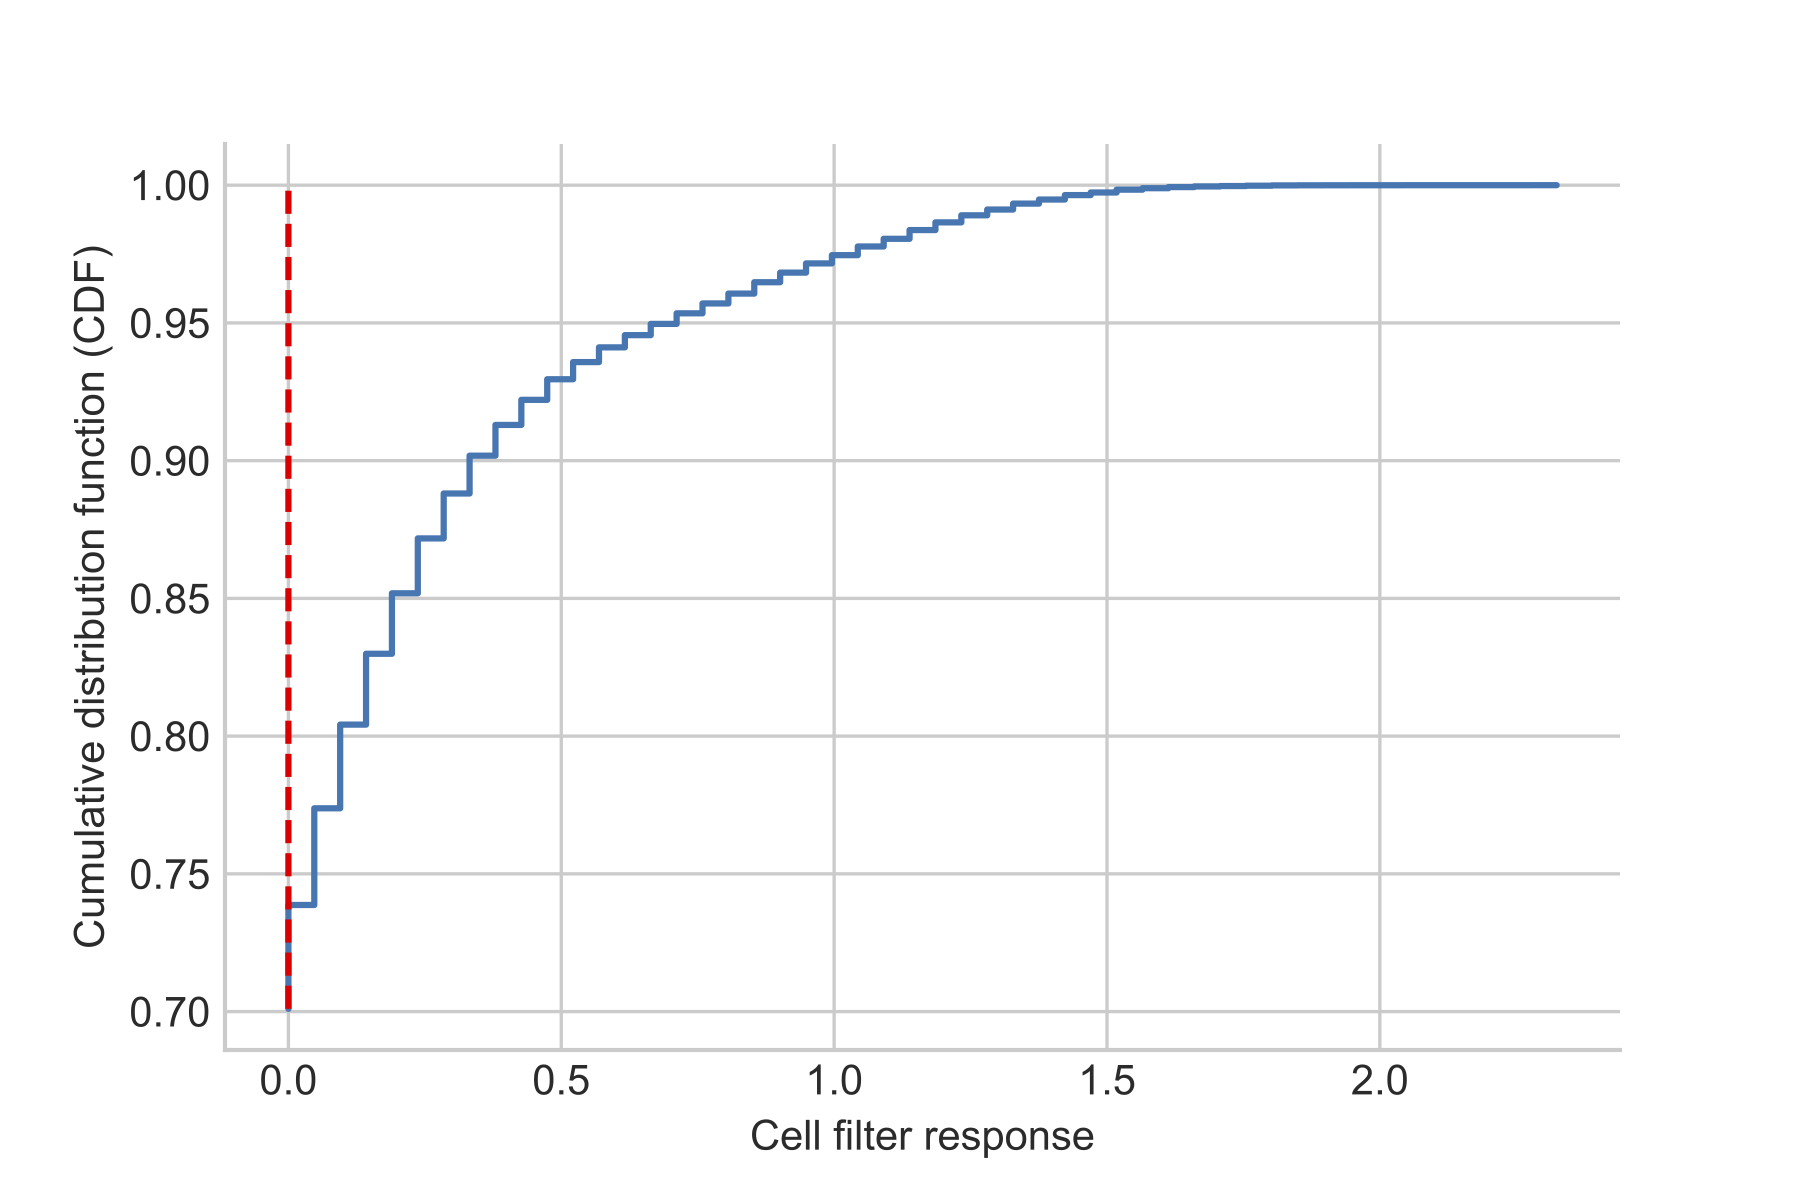

In [25]:
# For filters selected as discriminative via the previously described step,
# we can inspect the cumulative distribution function (CDF) of the cell filter response.
# Based on this, we can pick a threshold on the cell filter response of the selected
# cell population. The default value for this threshold is `filter_response_thres`=0.

Image("./output_NK/cdf_filter_0.png", width=600, height=350)

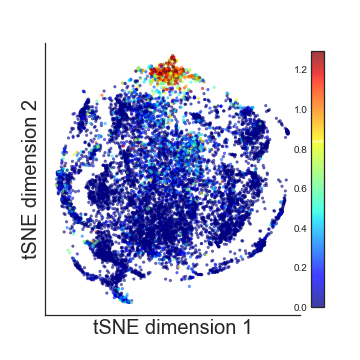

In [30]:
# We can take a look at cell filter responses overlaid on a t-SNE map
# This plots can give us a hint about a suitable filter response cutoff threshold for the selected population.
# Here a reasonable value for this threshold is e.g. 0.7

Image("./output_NK/tsne_cell_response_filter_0.png")

In [ ]:
# We plot again, now using a more stringent cutoff (filter_response_thres=0.7)
# on the cell filter response of the selected cell population.

_ = plot_results(model.results, test_samples, test_phenotypes,
                 markers, OUTDIR, filter_response_thres=0.7,
                 filter_diff_thres=0.2, group_a='CMV-', group_b='CMV+')

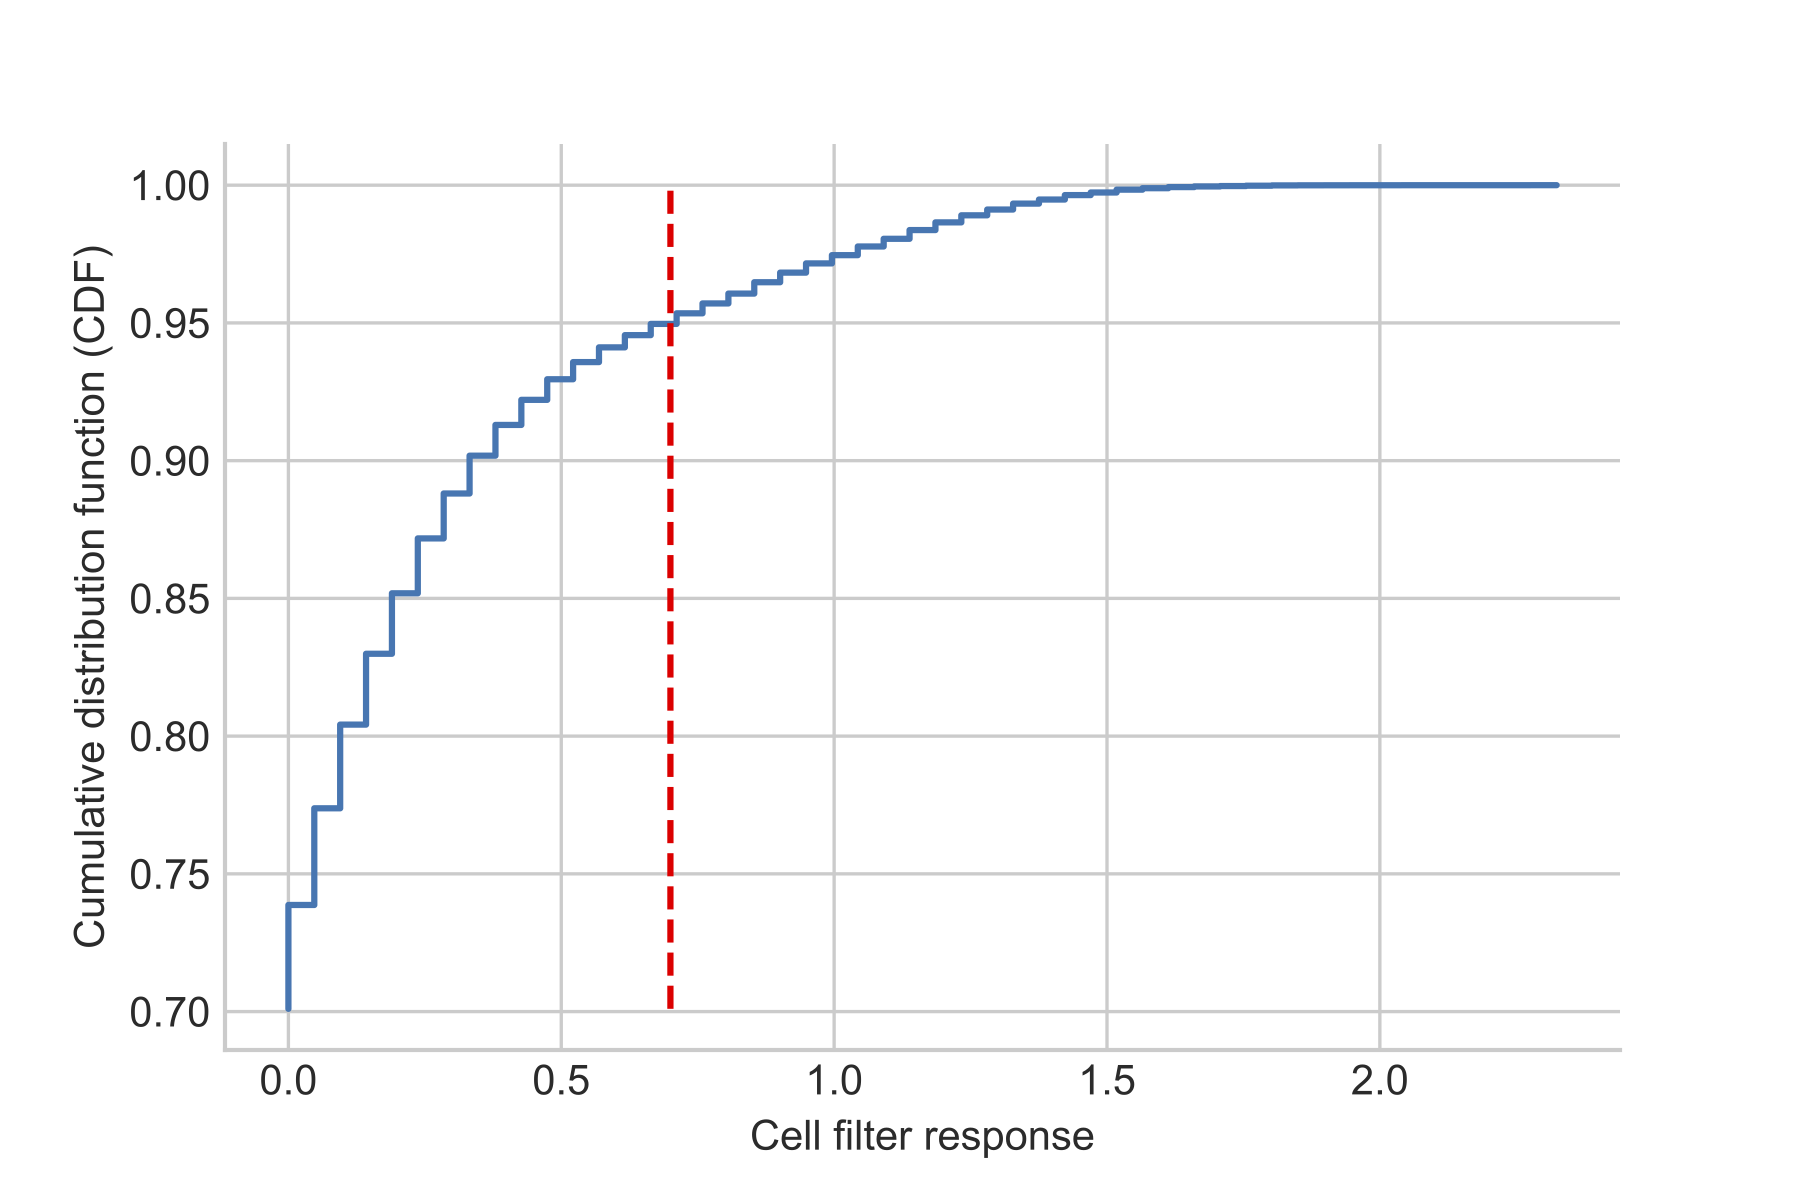

In [32]:
Image("./output_NK/cdf_filter_0.png", width=600, height=350)

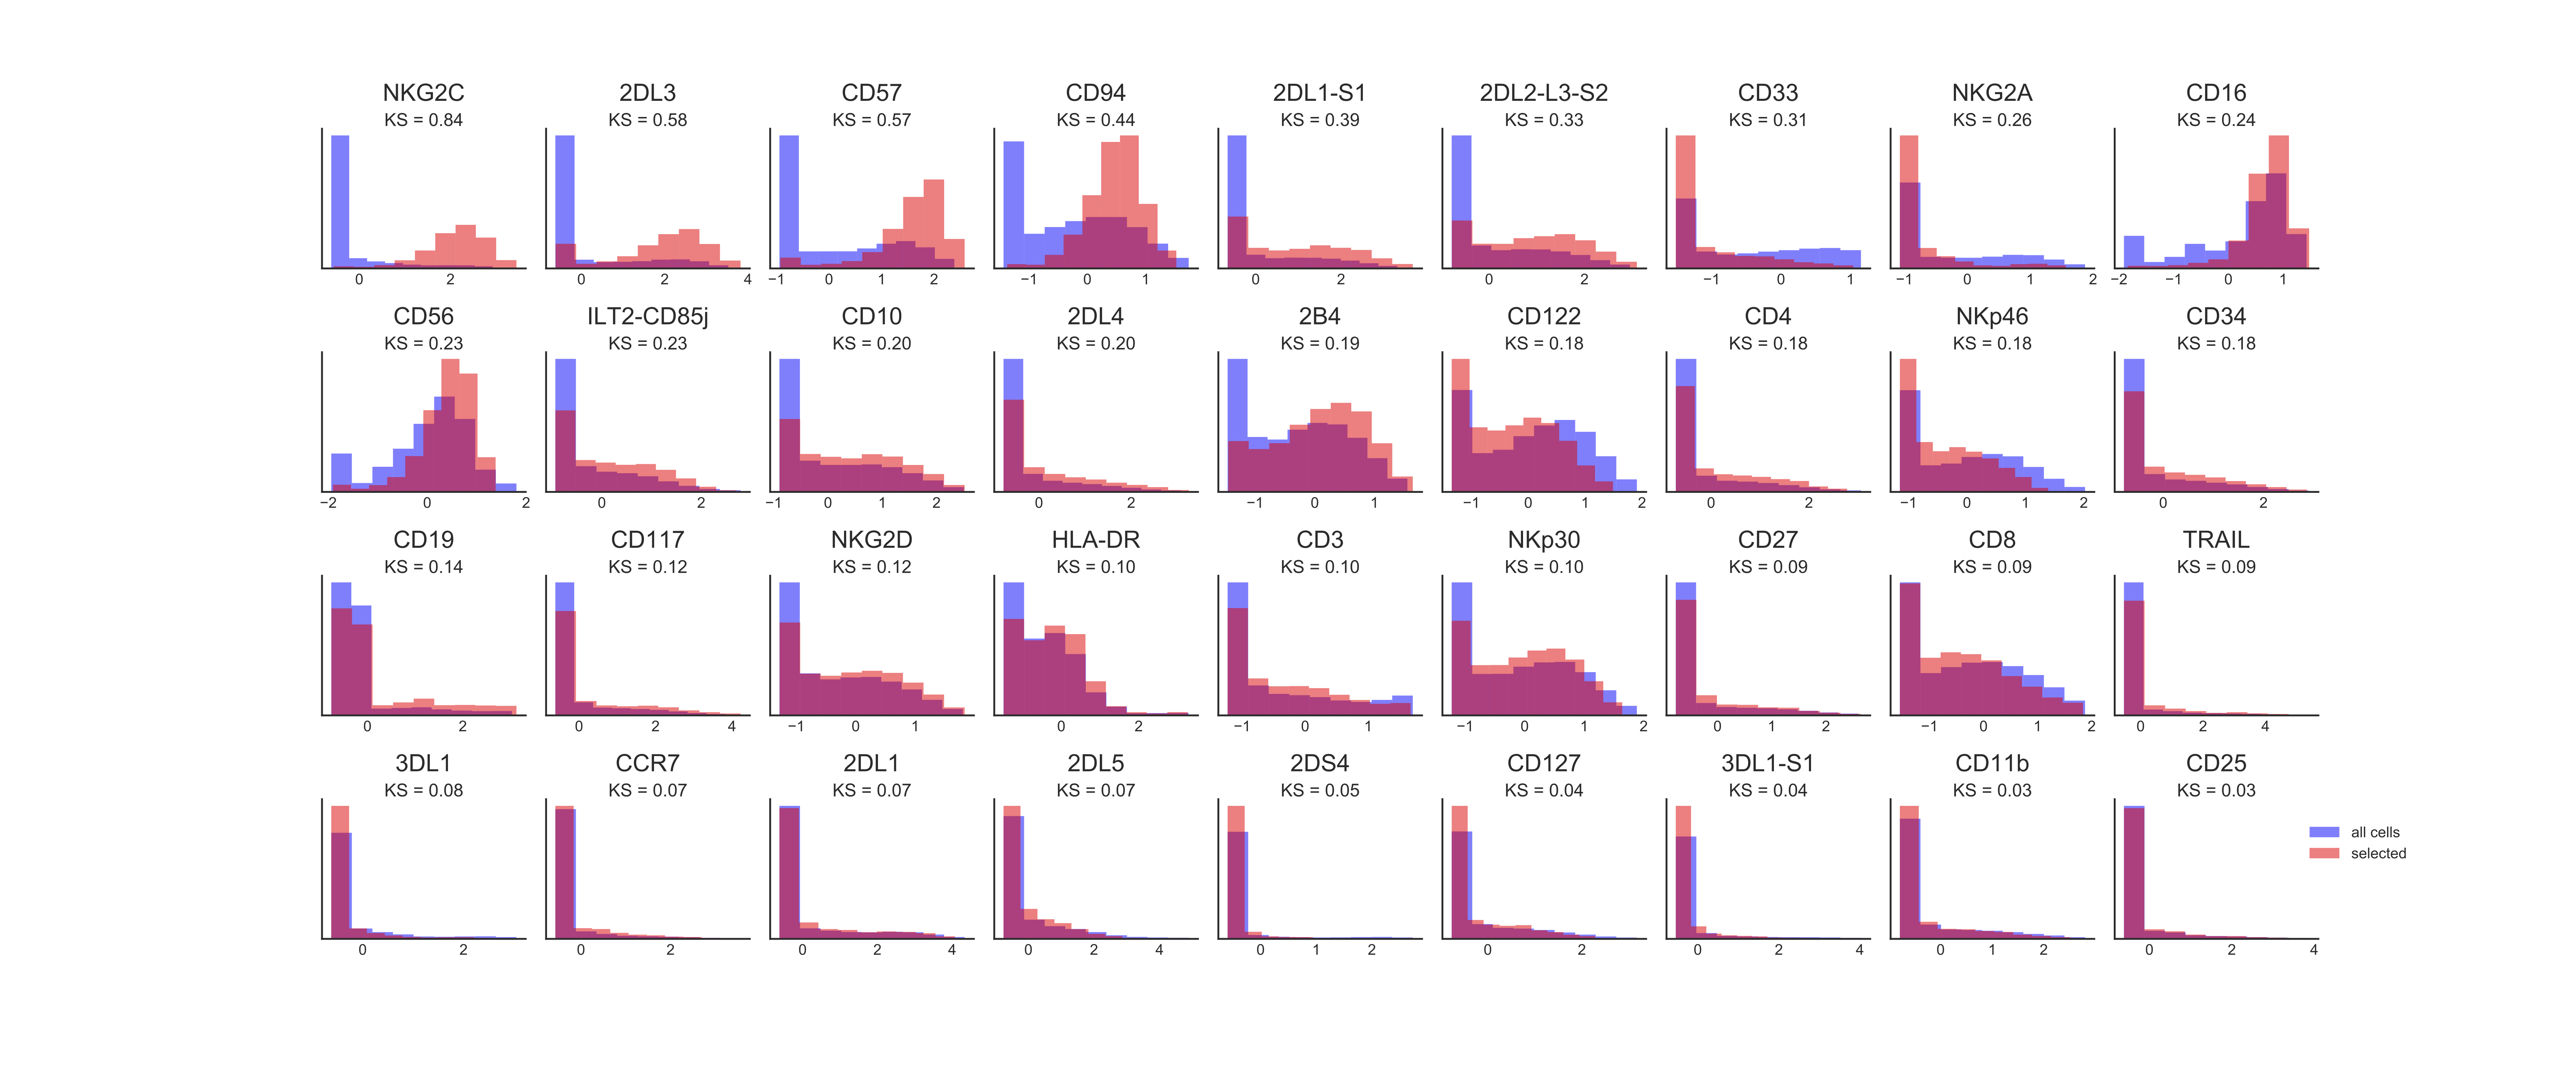

In [33]:
# Marker abundance histograms of each selected cell population are compared
# with the corresponding marker abundance histograms of all cells. The distance between
# distributions is quantified via the Kolmogorov-Smirnov (KS) statistic.

# Here the selected cell population is now a CD57+ NKG2C+ NK cell subset

Image("./output_NK/selected_population_distribution_filter_0.png")

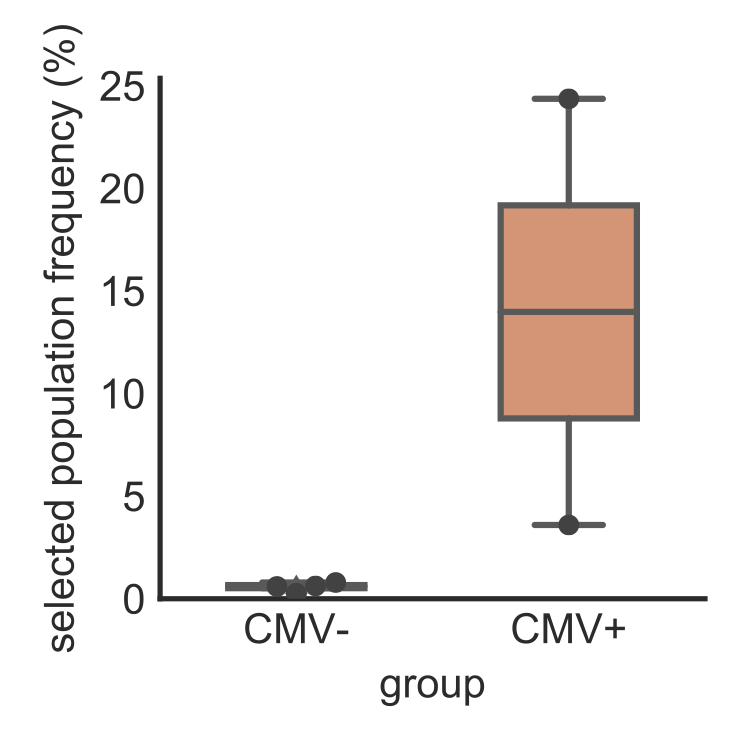

In [37]:
# For binary classification problems, we also get a boxplot of frequencies of the selected
# cell population in samples of the two classes.

Image("./output_NK/selected_population_frequencies_filter_0.png", width=300, height=175)